# Non linear feature extraction of the stratosphere

- https://github.com/geopandas/geopandas/issues/1166

## Data exploration:

In [1]:
#imports:
from scipy.spatial import distance_matrix
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
#from mpl_toolkits.basemap import Basemap
#import cartopy
import networkx as nx
from tqdm import tqdm
from time import sleep
%load_ext jupyternotify
import warnings
warnings.filterwarnings('ignore')

from sklearn.neighbors import NearestNeighbors

import scipy.sparse.linalg as linalg
import scipy.signal as signal

import seaborn as sns
import matplotlib.dates as mdates
from datetime import datetime


<IPython.core.display.Javascript object>

### Load data: 

In [2]:
data_path = '../../../data/vandermeer/input_data/'
anomalies_cf = pd.read_csv(data_path+'anomalies_coefficients.csv', sep=',')
raw_cf = pd.read_csv(data_path+'raw_data_coefficients.csv', sep=',')
basis_cf = pd.read_csv(data_path+'basis_functions.csv', sep=',')

In [3]:
basis_cf.head(3)

,Unnamed: 0,Lon,Lat,X1,X2,X3,X4,X5,X6,X7,...,X992,X993,X994,X995,X996,X997,X998,X999,X1000,X1001
0,1,0.00,89.25,1,0.010141,0.040319,-2.368483,0.001031,0.000077,-0.102981,...,3.631613e-13,3.464664e-14,-3.341165e-13,2.849425e-13,1.557925e-13,5.982969e-13,6.331329e-13,2.241741e-13,-2.846185e-13,-5.775125e-13
1,2,0.75,89.25,1,0.009612,0.040449,-2.368483,0.001029,0.000104,-0.101771,...,4.067050e-13,-4.938318e-16,-3.507720e-13,2.985671e-13,1.810982e-13,5.570756e-13,6.526212e-13,1.829743e-13,-3.911114e-13,-5.002182e-13
2,3,1.50,89.25,1,0.009082,0.040571,-2.368483,0.001026,0.000131,-0.100545,...,3.982352e-13,-3.830620e-14,-4.210252e-13,2.607462e-13,1.647441e-13,5.954190e-13,6.264252e-13,2.505362e-13,-4.883408e-13,-3.861563e-13


In [4]:
raw_cf.head(3)

,Unnamed: 0,Date,X1,X2,X3,X4,X5,X6,X7,X8,...,X992,X993,X994,X995,X996,X997,X998,X999,X1000,X1001
0,1,1979-01-01 00:00:00,0.000443,0.000059,0.000018,-0.000257,0.000027,0.000018,-0.000047,-0.000025,...,1.326600e-06,-2.590231e-07,1.111734e-06,-7.988864e-07,4.408012e-08,-1.217306e-08,9.282409e-07,-5.001676e-07,-4.883183e-08,1.128947e-06
1,2,1979-01-01 06:00:00,0.000436,0.000057,0.000017,-0.000250,0.000028,0.000011,-0.000043,-0.000030,...,3.176703e-07,-2.685431e-07,5.769547e-08,6.127967e-07,4.295968e-08,-7.938383e-08,1.063049e-06,-5.364016e-07,7.481122e-07,2.706997e-07
2,3,1979-01-01 12:00:00,0.000434,0.000058,0.000010,-0.000249,0.000034,0.000009,-0.000043,-0.000029,...,1.135065e-06,-1.217742e-06,1.196999e-07,-2.562468e-07,-6.708924e-08,7.292826e-08,1.581833e-07,-4.967490e-07,-8.876771e-08,-9.832148e-07


In [5]:
anomalies_cf.head(3)

,Unnamed: 0,Date,X1,X2,X3,X4,X5,X6,X7,X8,...,X992,X993,X994,X995,X996,X997,X998,X999,X1000,X1001
0,1,1979-01-01 00:00:00,0.087772,0.306971,-0.358278,-0.713848,0.431876,0.233288,0.079006,0.182841,...,0.010085,0.000343,0.013018,-0.008956,0.001028,-0.000141,0.009586,-0.004209,0.000906,0.011727
1,2,1979-01-01 06:00:00,0.045790,0.298297,-0.373760,-0.684706,0.456666,0.171122,0.098944,0.153985,...,0.004224,-0.002052,0.002568,0.003769,0.000829,-0.001214,0.010168,-0.005202,0.007966,0.002296
2,3,1979-01-01 12:00:00,0.044001,0.297177,-0.449389,-0.679847,0.513206,0.161827,0.082390,0.152011,...,0.009204,-0.010951,0.000831,-0.004194,-0.000835,0.001100,-0.000148,-0.005812,0.000562,-0.005325


In [ ]:
fig, axs = plt.subplots(1,2, figsize = (10, 5))
sns.histplot(raw_cf['X1'], ax = axs[0], bins = 15)
axs[0].set_xlabel('PV raw')
sns.histplot(anomalies_cf['X1'], ax = axs[1], bins = 15)
axs[1].set_xlabel('PV anomalies')

In [ ]:
plt.hist(raw_cf['X1'])

In [ ]:
# Sample `February 6th 1981 at 6AM':
date = '1981-02-06 06:00:00'
df = anomalies_cf
sample_df = df[df.Date == date]

In [ ]:
# Look at small sample of data:
#sample_anomaly = anomalies_cf.sample(1)
sample_array = np.array(sample_df.drop(['Unnamed: 0', 'Date'], axis=1))
basis_array = np.array(basis_cf.drop(['Unnamed: 0', 'Lon', 'Lat'], axis=1))

print(
    f'Coordinates shape:{sample_array.shape} and Basis array shape:{basis_array.shape}'
)

In [ ]:
def basis_transf(coordinates, basis):
    """
    @input: 
    - basis np.array of shape (1001, 38400)
    - coordinates np.array of shape (1001, 1)
    """
    x = np.zeros(38400)
    if coordinates.shape == (1, 1001):
        coordinates = coordinates.T
    if basis.shape == (38400, 1001):
        basis = basis.T
    for i in range(len(coordinates)):
        x += coordinates[i] * basis[i]
    return x

In [ ]:
# Apply basis transformation to sample point:
X_sample = pd.DataFrame(
    data={
        'longitude': basis_cf['Lon'],
        'latitude': basis_cf['Lat'],
        'PV_values': basis_transf(sample_array, basis_array)
    })

In [ ]:
def plot_sample(X_sample, option = 'color'):
    Z = X_sample.pivot(index='latitude',
                       columns='longitude',
                       values='PV_values')

    fig = plt.figure(figsize=(8, 8))

    m = Basemap(projection='npstere', boundinglat=28, lon_0=0, resolution='l')
    m.drawcoastlines()
    m.drawparallels(np.arange(-80., 81., 20.),
                    labels=[False, False, False, False])
    m.drawmeridians(np.arange(-180., 181., 20.),
                    labels=[True, False, True, True])
    
    latitude = Z.index.values
    longitude = Z.columns.values
    
    lons, lats = np.meshgrid(longitude, latitude)
    if option == 'color':
        m.pcolor(lons, lats, Z.values, latlon=True, cmap='RdYlBu')
    if option == 'contour':
        m.contourf(lons, lats, Z.values, latlon=True, cmap='RdYlBu')
    m.colorbar()

In [ ]:
plot_sample(X_sample, 'color')

In [ ]:
df_test = pd.DataFrame(
    data={
        'longitude': basis_cf['Lon'],
        'latitude': basis_cf['Lat'],
        'PV_values': basis_cf['X2']
    })

Z_ = df_test.pivot(index='latitude', columns='longitude', values='PV_values')

fig = plt.figure(figsize=(10, 15))

#m = Basemap(projection='npstere', boundinglat=28, lon_0=0, resolution='l')
m = Basemap(llcrnrlon=-180.,llcrnrlat=29.,urcrnrlon=180,urcrnrlat=90., projection='cyl')
m.drawcoastlines()

latitude = Z_.index.values
longitude = Z_.columns.values

lons, lats = np.meshgrid(longitude, latitude)
m.contourf(lons, lats, Z_.values, latlon=True, cmap='RdYlBu')

## PCA: 

In [ ]:
# Sample `February 6th 1981 at 6AM':
date = '1981-02-06 06:00:00'
df = anomalies_cf
sample_df = df[df.Date == date]
X = np.array(df.drop(['Unnamed: 0', 'Date'], axis=1))

In [ ]:
X.shape

In [ ]:
pca = PCA(n_components=10)
pca.fit(X)
singular_values_pca = pca.singular_values_
explained_variance_ratio__pca = pca.explained_variance_ratio_
components_pca = pca.components_

print("Singular values: {sv} \nExplained variance: {ev}".format(
    sv=singular_values_pca, ev=explained_variance_ratio__pca))

In [ ]:
X.shape, components_pca.shape, basis_transf(components_pca[0], basis_array).shape

In [ ]:
NUM_COMP = 5
fig, axs = plt.subplots(1, NUM_COMP, figsize=(20, 20))

for i in range(NUM_COMP):
    X_sample = pd.DataFrame(
        data={
            'longitude': basis_cf['Lon'],
            'latitude': basis_cf['Lat'],
            'PV_values': basis_transf(components_pca[i], basis_array)
        })

    Z = X_sample.pivot(index='latitude',
                       columns='longitude',
                       values='PV_values')
    
    lons, lats = np.meshgrid(Z.columns.values, Z.index.values)
    
    m = Basemap(projection='npstere',
                boundinglat=29,
                lon_0=0,
                resolution='l',
                ax=axs[i])
    m.drawcoastlines(ax=axs[i])
    m.drawparallels(np.arange(-80., 81., 20.),
                    labels=[False, False, False, False],
                    ax=axs[i])
    m.drawmeridians(np.arange(-180., 181., 20.),
                    labels=[True, False, False, True],
                    ax=axs[i])
    
    m.pcolor(lons, lats, Z.values, latlon=True, cmap='RdYlBu', ax=axs[i])
    
    axs[i].set_title('Component: {}, variance: {:.2f}'.format(
        i + 1, explained_variance_ratio_[i] * 100))

plt.savefig('../data/figures/PCA.png')

## Laplacian decomposition:

In [6]:
DATA = 'raw'

if DATA == 'raw':
    df = raw_cf
    PATH = '../../../data/vandermeer/pickles/raw/'
else: 
    df = anomalies_cf
    PATH = '../../../data/vandermeer/pickles/anomalies/'

df = df.drop(['Unnamed: 0','Date'], axis = 1)

In [7]:
df.head(3)

,X1,X2,X3,X4,X5,X6,X7,X8,X9,X10,...,X992,X993,X994,X995,X996,X997,X998,X999,X1000,X1001
0,0.000443,0.000059,0.000018,-0.000257,0.000027,0.000018,-0.000047,-0.000025,0.000042,0.000041,...,1.326600e-06,-2.590231e-07,1.111734e-06,-7.988864e-07,4.408012e-08,-1.217306e-08,9.282409e-07,-5.001676e-07,-4.883183e-08,1.128947e-06
1,0.000436,0.000057,0.000017,-0.000250,0.000028,0.000011,-0.000043,-0.000030,0.000038,0.000038,...,3.176703e-07,-2.685431e-07,5.769547e-08,6.127967e-07,4.295968e-08,-7.938383e-08,1.063049e-06,-5.364016e-07,7.481122e-07,2.706997e-07
2,0.000434,0.000058,0.000010,-0.000249,0.000034,0.000009,-0.000043,-0.000029,0.000032,0.000035,...,1.135065e-06,-1.217742e-06,1.196999e-07,-2.562468e-07,-6.708924e-08,7.292826e-08,1.581833e-07,-4.967490e-07,-8.876771e-08,-9.832148e-07


### Adjacency graph:

N neighbours %10 

#### Distance matrix:

Distance matrix with p-norm with p = 2. But not symetric ? 

In [ ]:
%%notify
"""
from scipy.spatial import distance_matrix
distance_df = pd.DataFrame(distance_matrix(df.values, df.values), index=df.index, columns=df.index)
distance_df.to_pickle(PATH+'distance_matrix.pkl')"""

In [8]:
distance_matrix = pd.read_pickle(PATH+'distance_matrix.pkl').values
distance_matrix

array([[0.00000000e+00, 4.94838369e-05, 6.31062937e-05, ...,
        3.08955859e-04, 3.09416953e-04, 3.12070736e-04],
       [4.94838369e-05, 0.00000000e+00, 4.79706087e-05, ...,
        3.01423668e-04, 3.01485121e-04, 3.03987727e-04],
       [6.31062937e-05, 4.79706087e-05, 0.00000000e+00, ...,
        3.00480053e-04, 3.00142279e-04, 3.02578389e-04],
       ...,
       [3.08955859e-04, 3.01423668e-04, 3.00480053e-04, ...,
        0.00000000e+00, 4.19059539e-05, 6.54091762e-05],
       [3.09416953e-04, 3.01485121e-04, 3.00142279e-04, ...,
        4.19059539e-05, 0.00000000e+00, 3.97417566e-05],
       [3.12070736e-04, 3.03987727e-04, 3.02578389e-04, ...,
        6.54091762e-05, 3.97417566e-05, 0.00000000e+00]])

In [53]:
pd.DataFrame(distance_matrix).head()

,0,1,2,3,4,5,6,7,8,9,...,33950,33951,33952,33953,33954,33955,33956,33957,33958,33959
0,0.000000,0.000049,0.000063,0.000071,0.000073,0.000083,0.000092,0.000101,0.000109,0.000119,...,0.000292,0.000298,0.000302,0.000306,0.000306,0.000309,0.000308,0.000309,0.000309,0.000312
1,0.000049,0.000000,0.000048,0.000062,0.000066,0.000072,0.000081,0.000092,0.000100,0.000109,...,0.000285,0.000291,0.000295,0.000299,0.000299,0.000302,0.000300,0.000301,0.000301,0.000304
2,0.000063,0.000048,0.000000,0.000047,0.000055,0.000063,0.000068,0.000078,0.000088,0.000098,...,0.000285,0.000292,0.000295,0.000299,0.000299,0.000301,0.000300,0.000300,0.000300,0.000303
3,0.000071,0.000062,0.000047,0.000000,0.000043,0.000055,0.000060,0.000071,0.000080,0.000091,...,0.000288,0.000295,0.000298,0.000302,0.000301,0.000304,0.000302,0.000303,0.000302,0.000305
4,0.000073,0.000066,0.000055,0.000043,0.000000,0.000042,0.000054,0.000067,0.000075,0.000086,...,0.000288,0.000295,0.000298,0.000302,0.000301,0.000303,0.000301,0.000302,0.000301,0.000303


In [ ]:
# Check if is symmetric:
np.all(distance_matrix.T == distance_matrix)

In [ ]:
distance_matrix.shape

#### Neighbour matrix:

One direction: -> 

In [ ]:
"""%%notify
K = int(len(df.values)*0.1)
N = len(distance_matrix)
weight_matrix = np.zeros((N,N))

for i in range(N):
    indices = np.argsort(distance_matrix[i])[:K]
    for j in indices: 
        if i!=j and weight_matrix[i,j] == 0: 
            weight_matrix[i,j] += 1"""
"""weight_matrix = weight_matrix.T
for i in range(N):
    indices = np.argsort(distance_matrix.T[i])[:K]
    for j in indices: 
        if i!=j and weight_matrix[i,j] == 0:
            weight_matrix[i,j] += 1
weight_df = pd.DataFrame(weight_matrix)
weight_df.to_pickle(PATH+'weight_matrix.pkl')"""

In [9]:
weight_m = pd.read_pickle(PATH+'simple_kernel/weight_matrix.pkl').values
weight_m

array([[0., 1., 1., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       [1., 1., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 1., 1.],
       [0., 0., 0., ..., 1., 0., 1.],
       [0., 0., 0., ..., 1., 1., 0.]])

In [55]:
pd.DataFrame(weight_m).head()

,0,1,2,3,4,5,6,7,8,9,...,33950,33951,33952,33953,33954,33955,33956,33957,33958,33959
0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.imshow(weight_m)

In [ ]:
# Test if matrix is symetric: 
np.all(weight_m.T == weight_m)

### Heat matrix: 

#### Choice of t:

In [53]:
mult_df = np.multiply(distance_matrix, weight_m)

mean_distances = np.mean(mult_df)
max_distances = np.max(mult_df)
t = [mean_distances, max_distances]
ts = {
    'mean_distances': mean_distances,
    'max_distances': max_distances,
    'mean_dist_all':np.mean(distance_matrix)
}
ts

{'mean_distances': 1.9120933791892165e-05,
 'max_distances': 0.0002519566442999222,
 'mean_dist_all': 0.00018081015819586767}

In [54]:
ts

{'mean_distances': 1.9120933791892165e-05,
 'max_distances': 0.0002519566442999222,
 'mean_dist_all': 0.00018081015819586767}

In [34]:
non_zero_mult = np.extract(mult_df>0, mult_df)

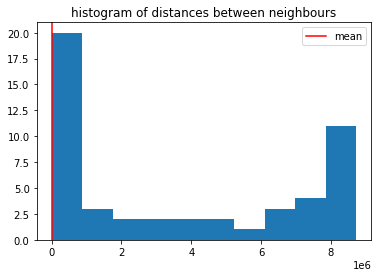

In [45]:
hist, bin_edges = np.histogram(non_zero_mult, bins = 50)
plt.hist(hist)
plt.title('histogram of distances between neighbours')
plt.axvline(t[0], color = 'red', label = 'mean')
plt.legend()

#### Heat matrix: 

In [ ]:
import os
for i in t: 
    if not os.path.exists(PATH+'t_'+str(chosen_t)+'/'):
        os.makedirs(PATH+'t_'+str(chosen_t)+'/')

In [26]:
! ls ../../../data/vandermeer/pickles/raw/t_1.9120933791892165e-05/

In [15]:
chosen_t = t[0]
PATH2 = PATH+'t_'+str(chosen_t)+'/'
PATH2

'../../../data/vandermeer/pickles/raw/t_1.9120933791892165e-05/'

In [27]:
distance_df = pd.DataFrame(distance_matrix)
heat_matrix_df = distance_df.apply(lambda x: np.exp(-(x**2) / (chosen_t**2)))
heat_matrix_df = pd.DataFrame(np.multiply(weight_m, heat_matrix_df))

In [17]:
heat_matrix_df.to_pickle(PATH2+'heat_matrix_'+str(chosen_t)+ '_.pkl')

In [18]:
heat_matrix = pd.read_pickle(PATH2+'heat_matrix_'+str(chosen_t)+'_.pkl').values

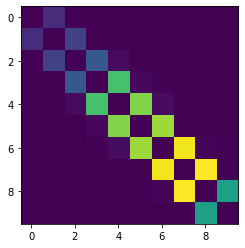

In [28]:
plt.imshow(heat_matrix[:10,:10])

In [29]:
pd.DataFrame(heat_matrix).head()

,0,1,2,3,4,5,6,7,8,9,...,33950,33951,33952,33953,33954,33955,33956,33957,33958,33959
0,0.000000e+00,0.001234,0.000019,0.000001,4.060392e-07,6.182382e-09,9.827382e-11,7.912132e-13,7.815603e-15,1.784287e-17,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.234073e-03,0.000000,0.001847,0.000025,6.966719e-06,6.374864e-07,1.288662e-08,9.411401e-11,1.292944e-12,7.517815e-15,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.859738e-05,0.001847,0.000000,0.002639,2.266178e-04,1.897438e-05,3.071941e-06,5.907633e-08,7.274896e-10,3.006967e-12,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.195045e-06,0.000025,0.002639,0.000000,6.778853e-03,2.243974e-04,5.079322e-05,1.062110e-06,3.057020e-08,1.425356e-10,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4.060392e-07,0.000007,0.000227,0.006779,0.000000e+00,7.780728e-03,3.341066e-04,4.218084e-06,2.042346e-07,1.538563e-09,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


To choose t: look at distances and take mean or max of all distances among neighbours. Check if t is not the squared of distance. For large t we should have something close to what we have now. Notice that as t tends to 0, the heat kernel Ht(x, y) becomes increasingly localized and tends to Dirac’s δ-function. $w_ij = -exp||xi-xj||^2/t$

In [30]:
non_zero_heat = np.extract(heat_matrix>0, heat_matrix)

In [31]:
non_zero_heat

array([1.23407265e-03, 1.85973846e-05, 1.19504495e-06, ...,
       3.41347120e-08, 8.27745549e-06, 1.33009186e-02])

Text(0.5, 1.0, 'histogram of non zero values of heat matrix')

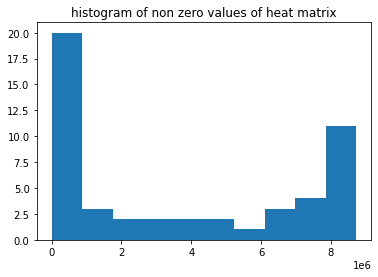

In [37]:
hist, bin_edges = np.histogram(non_zero_heat, bins = 50)
plt.hist(hist)
plt.title('histogram of non zero values of heat matrix')

#### Diagonal weight matrix: 
$D_{ii} = \sum_j W_{ij}$ Sum of each of the colons of W ? 

In [46]:
wm = heat_matrix
D = np.zeros((len(wm),len(wm)))
for i in tqdm(range(len(wm))):
    D[i,i] = np.sum(wm[i])
D_df = pd.DataFrame(D)
D_df.to_pickle(PATH2+'diagonal_heat_matrix_'+str(chosen_t)+'_.pkl')

100%|██████████| 33960/33960 [00:34<00:00, 976.73it/s] 


In [47]:
D = pd.read_pickle(PATH2+'diagonal_heat_matrix_'+str(chosen_t)+'_.pkl').values

In [12]:
pd.DataFrame(D)

,0,1,2,3,4,5,6,7,8,9,...,33950,33951,33952,33953,33954,33955,33956,33957,33958,33959
0,0.001254,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
1,0.000000,0.003114,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
2,0.000000,0.000000,0.004754,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
3,0.000000,0.000000,0.000000,0.00972,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
4,0.000000,0.000000,0.000000,0.00000,0.015132,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33955,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.012564,0.000000,0.000000,0.00000,0.000000
33956,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.016543,0.000000,0.00000,0.000000
33957,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.017164,0.00000,0.000000
33958,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.02153,0.000000


In [36]:
D.shape

(33960, 33960)

(array([28027.,  3201.,  1575.,   485.,   223.,   114.,   134.,    95.,
           74.,    32.]),
 array([6.25438047e-17, 1.51974595e+00, 3.03949190e+00, 4.55923785e+00,
        6.07898380e+00, 7.59872975e+00, 9.11847571e+00, 1.06382217e+01,
        1.21579676e+01, 1.36777136e+01, 1.51974595e+01]),
 <BarContainer object of 10 artists>)

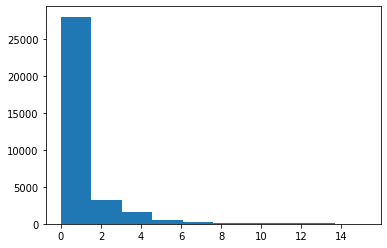

In [47]:
plt.hist(np.diagonal(D))

### Laplacian matrix: 

$L = D- W$

In [48]:
%%notify
wm = heat_matrix
L = np.subtract(D, wm)
L_df = pd.DataFrame(L)
L_df.to_pickle(PATH2+'laplacian_heat_matrix_'+str(chosen_t)+'_.pkl')

<IPython.core.display.Javascript object>

In [48]:
L = pd.read_pickle(PATH2+'laplacian_heat_matrix_'+str(chosen_t)+'_.pkl').values

In [15]:
L.shape

(33960, 33960)

In [51]:
pd.DataFrame(L)

,0,1,2,3,4,5,6,7,8,9,...,33950,33951,33952,33953,33954,33955,33956,33957,33958,33959
0,1.254277e-03,-0.001234,-0.000019,-0.000001,-4.060392e-07,-6.182382e-09,-9.827382e-11,-7.912132e-13,-7.815603e-15,-1.784287e-17,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
1,-1.234073e-03,0.003114,-0.001847,-0.000025,-6.966719e-06,-6.374864e-07,-1.288662e-08,-9.411401e-11,-1.292944e-12,-7.517815e-15,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
2,-1.859738e-05,-0.001847,0.004754,-0.002639,-2.266178e-04,-1.897438e-05,-3.071941e-06,-5.907633e-08,-7.274896e-10,-3.006967e-12,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
3,-1.195045e-06,-0.000025,-0.002639,0.009720,-6.778853e-03,-2.243974e-04,-5.079322e-05,-1.062110e-06,-3.057020e-08,-1.425356e-10,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
4,-4.060392e-07,-0.000007,-0.000227,-0.006779,1.513210e-02,-7.780728e-03,-3.341066e-04,-4.218084e-06,-2.042346e-07,-1.538563e-09,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
33955,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-3.640149e-21,-8.164729e-17,-3.055399e-11,-1.525001e-06,-4.998285e-03,1.256375e-02,-7.562162e-03,-0.000002,-4.863151e-10,-2.812319e-13
33956,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-3.783178e-25,-9.009453e-22,-1.410258e-15,-1.035573e-10,-4.360889e-06,-7.562162e-03,1.654337e-02,-0.008951,-2.581223e-05,-3.413471e-08
33957,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-1.304526e-29,-2.412177e-26,-1.981403e-20,-2.639742e-15,-4.257174e-10,-1.780254e-06,-8.951003e-03,0.017164,-8.203218e-03,-8.277455e-06
33958,0.000000e+00,0.000000,0.000000,0.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,...,-2.420985e-33,-1.083550e-30,-1.769465e-24,-2.329994e-19,-6.628779e-14,-4.863151e-10,-2.581223e-05,-0.008203,2.152995e-02,-1.330092e-02


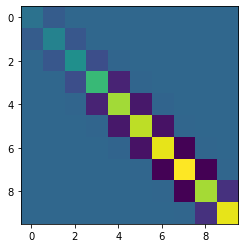

In [28]:
plt.imshow(L[:10,:10])

Text(0.5, 1.0, 'histogram of non zero values of laplacian matrix')

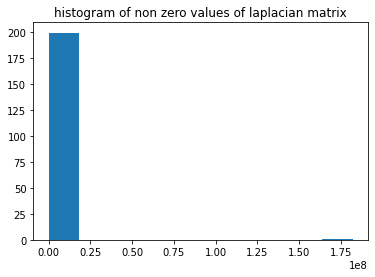

In [52]:
non_zero_L = np.extract(L!=0, L)
hist, bin_edges = np.histogram(non_zero_L, bins = 200)
plt.hist(hist)
plt.title('histogram of non zero values of laplacian matrix')

#### Eigenvalues: 

Eigendecomposition, check only one connected component

In [49]:
%%time
w, eigv = linalg.eigs(L, k=10, M=D, which='SM')
pd.DataFrame(w).to_pickle(PATH2 + 'eigenvalues_heat_matrix_' + str(chosen_t) +
                          '_.pkl')
pd.DataFrame(eigv).to_pickle(PATH2 + 'eigenvectors_heat_matrix_' +
                             str(chosen_t) + '_.pkl')

CPU times: user 25min 22s, sys: 5min 52s, total: 31min 14s
Wall time: 4min 18s


In [50]:
w = pd.read_pickle(PATH2+'eigenvalues_heat_matrix_'+str(chosen_t)+'_.pkl')
eigv = pd.read_pickle(PATH2+'eigenvectors_heat_matrix_'+str(chosen_t)+'_.pkl')

$X'_i = X \phi_i \phi_i^T, \phi \in R^{33960}, X \in R^{Nx1001} : data$ or with linear regression, plot also time-series and power spectrum. on raw data, 1st mdode should match some patter n everyr 6months

scipy- sparse linalg eigs, generalized decomposition (package ?) eigs in scipy https://spectralib.org/
wich prameter in linalg.eigs. --> SM check what they mean with magnitude, same as value ? 

In [ ]:
! ls ../../../data/vandermeer/pickles/raw/

In [ ]:
! ls ../../../data/vandermeer/pickles/raw/t_0.00018081015819586767

#### Create plots for all t:

In [ ]:
ts 

In [ ]:
possible_t = [
    0.00018081015819586767, 0.0004674197965411565, 2.1848126619857615e-07,
    3.269231330681469e-08, 0.001, 0.01, 0.1, 1
]
for chosen_t in possible_t:
    PATH2 = PATH + f't_{chosen_t}/'
    w = pd.read_pickle(PATH2 + 'eigenvalues_heat_matrix_' + str(chosen_t) +
                       '_.pkl').values
    eigv = pd.read_pickle(PATH2 + 'eigenvectors_heat_matrix_' + str(chosen_t) +
                          '_.pkl').values

    time = raw_cf['Date']
    time = pd.to_datetime(time)
    eigv_time = pd.concat([time, pd.DataFrame(eigv)], axis=1)
    eigv_time = eigv_time.set_index('Date')
    
    # plot eigenvalues:
    plot_eigenvalues(w, chosen_t)
    
    # plot all eigenvectors for all years:
    plot_all_eig(eigv_time, chosen_t)
    
    # plot all eigenvectors for one winter:
    plot_one_winter(eigv_time, chosen_t)
    
    # plot winters supperposés:
    winters_supp(eigv_time, chosen_t)
    
    # plot a few winters:
    plot_few_years(eigv_time, chosen_t)
    
    # power spectrum:
    pwr_compl(eigv_time, sampling_rate_days, chosen_t)

In [ ]:
for chosen_t in possible_t:
    PATH2 = PATH + f't_{chosen_t}/'
    w = pd.read_pickle(PATH2 + 'eigenvalues_heat_matrix_' + str(chosen_t) +
                       '_.pkl').values
    eigv = pd.read_pickle(PATH2 + 'eigenvectors_heat_matrix_' + str(chosen_t) +
                          '_.pkl').values
    print('Eigenvalues for t {}:  \n {}'.format(round(chosen_t, 5), w))

#### For one special t: 

In [ ]:
ts

In [ ]:
"""
w, eigv = linalg.eigs(L.values, k=10, M=D, which='SM')
pd.DataFrame(w).to_pickle(PATH + 'eigenvalues_heat_matrix_' + str(chosen_t) +
                          '_.pkl')
pd.DataFrame(eigv).to_pickle(PATH + 'eigenvectors_heat_matrix_' +
                             str(chosen_t) + '_.pkl')
"""

In [ ]:
chosen_t = ts['mean_distances']
chosen_t2 = ts['mean_distances**2']
chosen_t3 = ts['max_distances']
chosen_t4 = ts['max_distances**2']

PATH2 = PATH + f't_{chosen_t}/'
PATH3 = PATH + f't_{chosen_t2}/'
PATH4 = PATH + f't_{chosen_t3}/'
PATH5 = PATH + f't_{chosen_t4}/'


w = pd.read_pickle(PATH2 + 'eigenvalues_heat_matrix_' + str(chosen_t) +
                       '_.pkl').values
eigv = pd.read_pickle(PATH2 + 'eigenvectors_heat_matrix_' + str(chosen_t) +
                          '_.pkl').values

w2 = pd.read_pickle(PATH3 + 'eigenvalues_heat_matrix_' + str(chosen_t2) +
                       '_.pkl').values
eigv2 = pd.read_pickle(PATH3 + 'eigenvectors_heat_matrix_' + str(chosen_t2) +
                          '_.pkl').values

w3 = pd.read_pickle(PATH4 + 'eigenvalues_heat_matrix_' + str(chosen_t3) +
                       '_.pkl').values
eigv3 = pd.read_pickle(PATH4 + 'eigenvectors_heat_matrix_' + str(chosen_t3) +
                          '_.pkl').values

w4 = pd.read_pickle(PATH5 + 'eigenvalues_heat_matrix_' + str(chosen_t4) +
                       '_.pkl').values
eigv4 = pd.read_pickle(PATH5 + 'eigenvectors_heat_matrix_' + str(chosen_t4) +
                          '_.pkl').values

In [ ]:
#w, w2, w3, w4

Plots of eigenvectors: 

In [ ]:
time = raw_cf['Date']
time = pd.to_datetime(time)
eigv_time = pd.concat([time, pd.DataFrame(eigv)], axis=1)
eigv_time = eigv_time.set_index('Date')

In [ ]:
time2 = raw_cf['Date']
time2 = pd.to_datetime(time)
eigv_time2 = pd.concat([time, pd.DataFrame(eigv2)], axis=1)
eigv_time2 = eigv_time2.set_index('Date')

In [ ]:
time3 = raw_cf['Date']
time3 = pd.to_datetime(time)
eigv_time3 = pd.concat([time, pd.DataFrame(eigv3)], axis=1)
eigv_time3 = eigv_time3.set_index('Date')

In [ ]:
time4 = raw_cf['Date']
time4 = pd.to_datetime(time)
eigv_time4 = pd.concat([time, pd.DataFrame(eigv4)], axis=1)
eigv_time4 = eigv_time4.set_index('Date')

## Tasks:

### Plot eigenvalues:

In [ ]:
def plot_eigenvalues(w, chosen_t):
    plt.scatter(x = range(0,10), y =w, marker='x')
    plt.title(f'Eigenvalues for t: {round(chosen_t,5)}')
    plt.savefig(f'images/eigenvalues/eigenvalues_{round(chosen_t,5)}.png')

In [ ]:
plt.scatter(x = range(0,10), y =w, marker='x', label = 'Mean dist')
plt.scatter(x = range(0,10), y =w2, marker='x', label = 'Mean dist**2')
plt.scatter(x = range(0,10), y =w3, marker='x', label = 'Max dist')
plt.scatter(x = range(0,10), y =w4, marker='x', label = 'Max dist**2')
plt.legend()
plt.title(f'Eigenvalues for t: {round(chosen_t,5)}')

### Plot all eigenvectors for all years:

In [ ]:
def plot_all_eig(eigv_time, chosen_t):
    fig, axs = plt.subplots(5, 2, figsize=(20, 20))
    m = 0
    for i in range(2):
        for j in range(5):
            axs[j, i].scatter(eigv_time[m].index,
                              eigv_time[m].values,
                              marker='.')
            axs[j, i].set_title(f"eigenvector {m}")
            m += 1
    plt.savefig(f'images/all_years/all_eig_all_years_{round(chosen_t,5)}.png')

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
m = 0
for i in range(2):
    for j in range(5):
        axs[j, i].scatter(eigv_time[m].index,
                              eigv_time[m].values,
                              marker='.', label = 'Mean dist')
        axs[j, i].scatter(eigv_time2[m].index,
                              eigv_time2[m].values,
                              marker='.', label = 'Mean dist**2')
        axs[j, i].scatter(eigv_time3[m].index,
                              eigv_time3[m].values,
                              marker='.', label = 'Max dist')
        axs[j, i].scatter(eigv_time4[m].index,
                              eigv_time4[m].values,
                              marker='.', label = 'Max dist**2')
        axs[j, i].set_title(f"eigenvector {m}")
        m += 1
plt.legend()

### Plot all eigenvectors for one year:

In [ ]:
def plot_one_year(eigv_time, chosen_t):
    fig, axs = plt.subplots(5, 2, figsize=(20, 20))
    m = 0
    for i in range(2):
        for j in range(5):
            axs[j, i].scatter(eigv_time[m]['2010'].index,
                              eigv_time[m]['2010'].values,
                              marker='.')
            axs[j, i].set_title(f"eigenvector {m}")
            m += 1
    plt.savefig(f'images/one_year/all_eig_one_year_{round(chosen_t,5)}.png')

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
m = 0
for i in range(2):
    for j in range(5):
        axs[j, i].scatter(eigv_time[m]['2010'].index,
                              eigv_time[m]['2010'].values,
                              marker='.',label = 'Mean dist')
        axs[j, i].scatter(eigv_time2[m]['2010'].index,
                              eigv_time2[m]['2010'].values,
                              marker='.', label = 'Mean dist**2')
        axs[j, i].scatter(eigv_time3[m]['2010'].index,
                              eigv_time3[m]['2010'].values,
                              marker='.', label = 'Max dist')
        axs[j, i].scatter(eigv_time4[m]['2010'].index,
                              eigv_time4[m]['2010'].values,
                              marker='.', label = 'Max dist**2')
        axs[j, i].set_title(f"eigenvector {m}")
        m += 1
plt.legend()

### Norm of eigenvectors:

Check order of eigenvectors. Try $y^T D y = 1$

In [ ]:
D = pd.read_pickle(PATH2 + 'diagonal_heat_matrix_' + str(chosen_t) +
                   '_.pkl').values

In [ ]:
D

In [ ]:
for i in eigv_time.columns:
    y = eigv_time[i]
    norm = y.T@D@y
    print(f'Eigenvector {i} has norm {norm}')

### Plot one winter (2008-2009):

In [ ]:
def plot_one_winter(eigv_time, chosen_t):
    fig, axs = plt.subplots(5, 2, figsize=(20, 20))
    m = 0
    for i in range(2):
        for j in range(5):
            winter_2008 = pd.date_range('2008-11', '2009-04')
            winter_2008_eig = eigv_time[m][winter_2008]
            axs[j, i].scatter(winter_2008_eig.index,
                              winter_2008_eig.values,
                              marker='.')
            axs[j, i].plot(winter_2008_eig.index,
                           winter_2008_eig.values,
                           color='green')
            axs[j, i].set_title(f"Winter of 2008-2009, eigenvector {m}")
            m += 1
    plt.savefig(
        f'images/one_winter/all_eig_one_winter_{round(chosen_t,5)}.png')

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(20, 20))
m = 0
for i in range(2):
    for j in range(5):
        winter_2008 = pd.date_range('2008-11', '2009-04')
        winter_2008_eig = eigv_time[m][winter_2008]
        winter_2008_eig2 = eigv_time2[m][winter_2008]
        winter_2008_eig3 = eigv_time3[m][winter_2008]
        winter_2008_eig4 = eigv_time4[m][winter_2008]

        axs[j, i].scatter(winter_2008_eig.index,
                              winter_2008_eig.values,
                              marker='.',label = 'Mean dist')
        axs[j, i].plot(winter_2008_eig.index,
                           winter_2008_eig.values,
                           color='grey')
        axs[j, i].scatter(winter_2008_eig2.index,
                              winter_2008_eig2.values,
                              marker='.',label = 'Mean dist**2')
        axs[j, i].plot(winter_2008_eig2.index,
                           winter_2008_eig2.values,
                           color='grey')
        axs[j, i].plot(winter_2008_eig4.index,
                           winter_2008_eig4.values,
                           color='grey')
        axs[j, i].plot(winter_2008_eig3.index,
                           winter_2008_eig3.values,
                           color='grey')
        axs[j, i].scatter(winter_2008_eig3.index,
                              winter_2008_eig3.values,
                              marker='.',label = 'Max dist')
        axs[j, i].scatter(winter_2008_eig4.index,
                              winter_2008_eig4.values,
                              marker='.',label = 'Max dist**2')
        axs[j, i].set_title(f"Winter of 2008-2009, eigenvector {m}")
        m += 1
plt.legend()

In [ ]:
fig, axs = plt.subplots(1, 3, figsize = (15,5))
m = 0
for i in range(3):
        winter_2008 = pd.date_range('2008-11', '2009-04')
        winter_2008_eig = eigv_time[m][winter_2008]
        winter_2008_eig2 = eigv_time2[m][winter_2008]
        winter_2008_eig3 = eigv_time3[m][winter_2008]
        winter_2008_eig4 = eigv_time4[m][winter_2008]

        axs[i].plot(winter_2008_eig.index,
                               winter_2008_eig.values,'-x',
                               label = 'Mean dist')
        axs[i].plot(winter_2008_eig2.index,
                               winter_2008_eig2.values
                               ,label = 'Mean dist**2')
        axs[i].plot(winter_2008_eig3.index,
                               winter_2008_eig3.values,label = 'Max dist')
        axs[i].plot(winter_2008_eig4.index,
                                  winter_2008_eig4.values,label = 'Max dist**2')
        axs[i].set_title(f"Winter of 2008-2009, eigenvector {m}")
        m+= 1
plt.legend()

### Plot overlapping winters:

In [ ]:
def transform_date(column):
    new_col = []
    year = column[0].year
    for i in column:
        month = i.month
        day = i.day

        if i.year > year:
            new_col.append(datetime(1984, month, day))
        else:
            new_col.append(datetime(1983, month, day))
    return new_col

In [ ]:
def winters_supp(eigv_time, chosen_t):
    years = eigv_time[0].index.year.unique()
    n = len(years)
    colors = plt.cm.jet(np.linspace(0, 1, n))
    fig, ax = plt.subplots(figsize=(20, 10))
    i = 0

    winter_eigs = []
    for year in years[:-1]:
        winter_of_that_year = pd.date_range(
            str(year) + '-11',
            str(year + 1) + '-04')
        winter_eig = eigv_time[0][winter_of_that_year]
        winter_eigs.append(winter_eig.values)
        #ax.plot(transform_date(winter_eig.index), winter_eig.values, label = year, color=colors[i])
        ax.plot(transform_date(winter_eig.index), winter_eig.values, color='grey')
        ax.set_xlabel('Winter')
        ax.set_title('Winters of the first eigenvector')
        ax.set_xticklabels(['Nov', 'Dec', 'Jan', 'Feb', 'Mar', 'Ap'])
        i += 1

    winter_of_that_year = pd.date_range(str(1979) + '-11', str(1979 + 1) + '-04')
    winter_eig = eigv_time[0][winter_of_that_year]
    df_winters = pd.DataFrame(winter_eigs).transpose()
    df_winters.index = transform_date(winter_eig.index)
    MEAN_WINTERS = df_winters.mean(axis=1)
    MEAN_WINTERS.index = transform_date(MEAN_WINTERS.index)
    MEDIAN_WINTERS = df_winters.median(axis=1)
    MEDIAN_WINTERS.index = transform_date(MEDIAN_WINTERS.index)

    ax.plot(MEAN_WINTERS, label='mean', color='r')
    ax.plot(MEDIAN_WINTERS, label='median', color='b')

    plt.legend()
    plt.savefig(f'images/winters_supperposed/winters_supp_{round(chosen_t,5)}.png')
    plt.show()

In [ ]:
winters_supp(eigv_time2, chosen_t)

In [ ]:
def plot_few_years(eigv_time, chosen_t):
        years = [1979,1980,1981,1982,1983,1985]
        n = len(years)
        colors = plt.cm.jet(np.linspace(0,1,n))
        fig, ax = plt.subplots()
        i = 0
        for year in years[:-1]:
            winter_of_that_year = pd.date_range(str(year)+'-11',str(year+1)+'-04')
            winter_eig = eigv_time[0][winter_of_that_year]
            ax.plot(transform_date(winter_eig.index), winter_eig.values, label = year, color=colors[i])
            ax.set_xlabel('Winter 1979-1985')
            ax.set_title('Winters of the first eigenvector')
            ax.set_xticklabels(['Nov','Dec','Jan','Feb','Mar','Ap'])
            i+= 1
        plt.legend()
        plt.savefig(f'images/winters_supperposed/few_winters{round(chosen_t,5)}.png')
        plt.show()

In [ ]:
plot_few_years(eigv_time2, chosen_t)

### Power Spectrums:
Power spectrum plot for all years and then see something every 7 months

In [ ]:
sampling_rate_seconds = 4 / (24 * 3600)
print(f'Frequency: {sampling_rate_seconds} [s-1]')
sampling_rate_days = 4
print(f'Frequency: {sampling_rate_days} [d-1]')
sampling_time = 1 / sampling_rate_days
print(f'Sampling every  {sampling_time*24} hours')

year_t = 365
two_year_t = (365 / 2)
three_year_t = (365 / 3)
freq_year = 1 / year_t
freq_two_year = 1 / two_year_t
freq_three_year = 1 / three_year_t

Pperations on frequency : log(frequency) -> in time 1/frequency
indicate the 1/year, 2/year and 3/year frequencie

Estimate power spectral density using a periodogram. Change to 1/frequency to time.

In [ ]:
def periodogram(eigv_time, sampling_rate_days, chosen_t):
    # Periodogram:
    f, Pxx_den = signal.periodogram(eigv_time[0], sampling_rate_days)

    fig, axs = plt.subplots(1, figsize=(10, 5))
    axs.semilogy(np.log(1 / f), Pxx_den)
    axs.axvline(np.log(year_t), color='r', label='Every year')
    axs.axvline(np.log(two_year_t), color='g', label='Twice per year')
    axs.axvline(np.log(three_year_t), color='orange', label='Thrice per year')
    axs.set_title("log(time [d])")
    axs.set_xticklabels(['0', '1', '7', '54', '403', '2980'])
    axs.set_xlabel('Days')
    plt.legend()
    
    plt.savefig(f'images/power_spectrum/pwr_spectrum{round(chosen_t,5)}.png')

In [ ]:
periodogram(eigv_time2, sampling_rate_days, chosen_t)

In [ ]:
"""
ticks = []
for ticklabel in axs.get_xticklabels():
     ticks.append(ticklabel.get_text())   
print(ticks)
ticks = [0, 2, 4, 6, 8]
np.floor(np.exp(ticks))
ticks = [0,1, 7, 54, 403, 2980]"""

In [ ]:
def pwr_compl(eigv_time, sampling_rate_days, chosen_t):
    full_time = pd.date_range(start='1/1/1979', end='1/1/2019', freq='6H')
    full_df = pd.DataFrame(np.zeros((len(full_time), 10)))
    full_df.index = full_time
    full_df.columns = [str(i) for i in eigv_time.columns]
    eigv_time.columns = [str(i) for i in eigv_time.columns]

    cols_to_use = full_df.transpose().columns.difference(
        eigv_time.transpose().columns)
    full_df_time = pd.merge(left=full_df.transpose()[cols_to_use],
                            right=eigv_time.transpose(),
                            how='right',
                            left_index=True,
                            right_index=True,
                            suffixes='_x').transpose()
    full_df_time = full_df_time.sort_index()
    f, Pxx_den = signal.periodogram(full_df_time['0'], sampling_rate_days)
    fig, axs = plt.subplots(1, figsize=(10, 5))
    axs.semilogy(np.log(1 / f), Pxx_den)
    axs.axvline(np.log(year_t), color='r', linestyle=':', label='Every year')
    axs.axvline(np.log(two_year_t),
                color='g',
                linestyle=':',
                label='Twice per year')
    axs.axvline(np.log(three_year_t),
                color='orange',
                linestyle=':',
                label='Thrice per year')
    axs.set_title("log(time [d])")
    axs.set_xticklabels(['0', '1', '7', '54', '403', '2980'])
    axs.set_xlabel('Days')
    plt.legend()
    plt.savefig(f'images/power_spectrum/pwr_spectrum{round(chosen_t,5)}.png')

In [ ]:
pwr_compl(eigv_time2, sampling_rate_days, chosen_t)

### Tasks: 
- First request a lot of eigenvectors and check that only one eigenvector that has eigenvalue close to zero (~$10^{-15}$) and might need to increase number of neighbours otherwise (check if graph is connected): **DONE FOR 50 EIGENVALUES, ONLY ONE ZERO**
- Take the mean over all winters : **DONE**
- Change to heat kernel and compute for different kernel values, and more than 10 eigenvectors. Plot also the eigenvalues. **DONE**
- To choose t: look at distances and take mean or max of all distances among neighbours. Check if t is not the squared of distance. For large t we should have something close to what we have now. 
- Move to anomaly data
- Power spectrum with missing data ? Compute power spectrum for other eigenvectors. So up to 7 months alright and then a gap and the rest should start at 360 and multiply by $365/(7x30)$ **DONE**

#### Where we are going next: 
- anomaly data estimated seasonality from raw data. estimate smooth mean and remove it to obtain the anomaly. 
- switch from default weight to gaussian kernel, optimise bandwidth computational demanding, try multiple experiments, assess the best bandwidth also define what best means
- apply also to anomaly data to see if consistent
- include to the model so that it can capture the dynamics of system, those things are called backends embedding (use multiple time steps to represent one sample -> sequences) —> apply and optimite previous all to new representation of data 

Pic raw data so that the first mode of variability should be the seasonality 
capturing something, huge variability but don’t know what

gaussian kernel approximates distance on manifold using this laplacian graph. The 0-1 weights is not very realistic because two samples that might be similar they might be different, For now they all have the sae weight. Not very good to approximate distances. For bandwidth t goes to 0 and a lot of data, converge to the distance on the manifold. 
